# Previsione dell'affidabilità creditizia per il rilascio della carta di credito
Sei stato assunto dalla Pro National Bank come data scientist, il tuo primo incarico consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia di un clienti, al fine di di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.<br><br>

A tal fine ti vengono consegnati i dati anonimizzati di clienti che hanno già ottenuto la carta di credito e lo stato del loro debito mensile. <br><br>

I dati sono organizzati in 2 file csv che possono essere scaricati [da qui](https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/credit_card_approval.zip).

Il tuo modello deve essere in grado di fornire un'indicazione al team sull'approvare o meno la richiesta di carta di credito per un dato cliente.<br><br>
### BONUS
Se ad un cliente viene negata la carta di credito, il team deve essere in grado di fornirgli una motivazione, questo vuol dire che il tuo modello deve fornire delle indicazioni facilmente interpretabili.
### NOTE
Come avrai notato manca una variabile target, non ti vogliamo dare indicazioni, sta a te capire come procedere. Qualora non riuscissi a venirne a capo chiedi pure una mano al tuo coach nella classe virtuale di Python su Discord.

In [1]:
#!wget https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/credit_card_approval.zip
#!unzip credit_card_approval.zip

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from time import time
from collections import Counter

# DATA IMPORT

In [3]:
APPLICATION_FILE = "application_record.csv"
CREDIT_FILE = "credit_record.csv"

appl = pd.read_csv(APPLICATION_FILE)
cred = pd.read_csv(CREDIT_FILE)

## Basic exploration of given datasets

In [4]:
appl.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
cred.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
cred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [8]:
# Nel primo dataset ci sono una manciata di ID duplicati che non dovrebbero esserci. 
print(appl["ID"].shape, appl["ID"].nunique())

# Nel secondo dataset c'è il credit record di 45985 ID distinti
print(cred["ID"].shape, cred["ID"].nunique())    

(438557,) 438510
(1048575,) 45985


In [9]:
# Droppo gli id duplicati nel primo dataset
appl = appl.drop_duplicates(subset=["ID"])

In [10]:
# Nel secondo dataset non ci sono valori nulli. Nel primo si, ma scelgo di occuparmene una volta
# uniti i due dataset (vista la natura del progetto)
appl.isna().sum().sum(), cred.isna().sum().sum()

(134193, 0)

# TARGET VARIABILE DEFINITION

In [11]:
df = cred[["ID", "STATUS"]].copy()
df["STATUS"].value_counts(normalize=True)*100    # Distribuzione di STATUS in percentuale

C    42.155401
0    36.537205
X    19.953747
1     1.057626
5     0.161457
2     0.082779
3     0.030518
4     0.021267
Name: STATUS, dtype: float64

Per avere una variabile target, faccio una sorta di media della variabile `STATUS` del dataset credit_record. Scelgo di considerare come status "buon pagatore" i seguenti codici:
* `X`: no loan for the month
* `C`: paid off that month
* `0`: 1-29 days past due  

e come status "cattivo pagatore" i codici rimanenti (`1`, `2`, `3`, `4`, `5`).  


Ho scelto così in base a [questo](https://www.laleggepertutti.it/242030_condizioni-per-avere-una-carta-di-credito#Le_garanzie) articolo. ("Effettuando acquisti che vanno oltre il credito presente, l’istituto bancario deve avere la certezza che il vostro debito rientrerà entro il mese seguente").



In [12]:
# Scelgo di considerare X, C, 0 come status "buono", i restanti come status "cattivo"

status_mapping = {"X": 1, "C": 1, "0": 1,
                  "1": 0, "2": 0, "3": 0, "4": 0, "5": 0}    # 1: GOOD, 0: BAD

df["STATUS"] = df["STATUS"].map(lambda t:status_mapping[t])

df = df.groupby("ID")["STATUS"].mean().reset_index()    # Per ogni cliente, STATUS diventa
                                              # la media di quanti mesi buoni/cattivi ha avuto
df.head(10)

,ID,STATUS
0,5001711,1.000000
1,5001712,1.000000
2,5001713,1.000000
3,5001714,1.000000
4,5001715,1.000000
5,5001717,1.000000
6,5001718,0.948718
7,5001719,1.000000
8,5001720,0.805556
9,5001723,1.000000


Immagino che un cliente con 1 mese da cattivo pagatore a fronte di tantissimi mesi da buon pagatore possa comunque ricevere la carta di credito.  

Come soglia, scelgo che un cliente deve avere almeno 5 mesi "buoni" ogni mese "cattivo" per essere considerato un buon pagatore.

In [13]:
GOOD_TO_BAD_MONTHS_RATIO_LIMIT = 5
boundary = GOOD_TO_BAD_MONTHS_RATIO_LIMIT / (1 + GOOD_TO_BAD_MONTHS_RATIO_LIMIT)
print("Boundary:", boundary)

df["STATUS"] = df["STATUS"].apply(lambda x: 1 if x >= boundary else 0)

df = df.rename(columns={"STATUS": "RELIABLE_CLIENT"})
print(df["RELIABLE_CLIENT"].value_counts())
df.head()

Boundary: 0.8333333333333334
1    44868
0     1117
Name: RELIABLE_CLIENT, dtype: int64


,ID,RELIABLE_CLIENT
0,5001711,1
1,5001712,1
2,5001713,1
3,5001714,1
4,5001715,1


# MERGING DATASETS

In [14]:
# Inner join per ottenere il dataset con tutti gli ID comuni a entrambi i dataset
merged_df = pd.merge(appl, df, on="ID", how="inner")

# Ho meno clienti di prima perché non tutti gli ID sono comuni a entrambi i dataset
print(merged_df["RELIABLE_CLIENT"].value_counts())
merged_df.head()

1    35478
0      979
Name: RELIABLE_CLIENT, dtype: int64


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,RELIABLE_CLIENT
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1


# EXPLORATORY DATA ANALYSIS 

In [15]:
df = merged_df.drop("ID", axis=1)
df.info()    # Noto che ci sono >10000 valori nulli in OCCUPATION_TYPE.
             # Prima esamino le altre variabili per valori anomali,
             # Poi sistemo questi valori mancanti

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          36457 non-null  object 
 1   FLAG_OWN_CAR         36457 non-null  object 
 2   FLAG_OWN_REALTY      36457 non-null  object 
 3   CNT_CHILDREN         36457 non-null  int64  
 4   AMT_INCOME_TOTAL     36457 non-null  float64
 5   NAME_INCOME_TYPE     36457 non-null  object 
 6   NAME_EDUCATION_TYPE  36457 non-null  object 
 7   NAME_FAMILY_STATUS   36457 non-null  object 
 8   NAME_HOUSING_TYPE    36457 non-null  object 
 9   DAYS_BIRTH           36457 non-null  int64  
 10  DAYS_EMPLOYED        36457 non-null  int64  
 11  FLAG_MOBIL           36457 non-null  int64  
 12  FLAG_WORK_PHONE      36457 non-null  int64  
 13  FLAG_PHONE           36457 non-null  int64  
 14  FLAG_EMAIL           36457 non-null  int64  
 15  OCCUPATION_TYPE      25134 non-null 

In [16]:
df.describe().transpose()    # Noto che c'è almeno un valore anomalo di DAYS_EMPLOYED positivo
                             # Le altre variabili numeriche sono in un intervallo realistico
                             # (anche se 19 figli sono un numero stratosferico)

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,36457.0,0.430315,0.742367,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,36457.0,186685.736662,101789.226482,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,36457.0,-15975.173382,4200.549944,-25152.0,-19438.0,-15563.0,-12462.0,-7489.0
DAYS_EMPLOYED,36457.0,59262.935568,137651.334859,-15713.0,-3153.0,-1552.0,-408.0,365243.0
FLAG_MOBIL,36457.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,36457.0,0.225526,0.417934,0.0,0.0,0.0,0.0,1.0
FLAG_PHONE,36457.0,0.294813,0.455965,0.0,0.0,0.0,1.0,1.0
FLAG_EMAIL,36457.0,0.089722,0.285787,0.0,0.0,0.0,0.0,1.0
CNT_FAM_MEMBERS,36457.0,2.198453,0.911686,1.0,2.0,2.0,3.0,20.0
RELIABLE_CLIENT,36457.0,0.973146,0.161658,0.0,1.0,1.0,1.0,1.0


In [17]:
for col in df.columns:
    print(col)
    print(df[col].value_counts(), '\n')    # Noto che FLAG_MOBIL == 1 per tutte le osservazioni

CODE_GENDER
F    24430
M    12027
Name: CODE_GENDER, dtype: int64 

FLAG_OWN_CAR
N    22614
Y    13843
Name: FLAG_OWN_CAR, dtype: int64 

FLAG_OWN_REALTY
Y    24506
N    11951
Name: FLAG_OWN_REALTY, dtype: int64 

CNT_CHILDREN
0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: CNT_CHILDREN, dtype: int64 

AMT_INCOME_TOTAL
135000.0    4309
180000.0    3097
157500.0    3089
112500.0    2956
225000.0    2926
            ... 
177750.0       1
594000.0       1
164250.0       1
124200.0       1
179271.0       1
Name: AMT_INCOME_TOTAL, Length: 265, dtype: int64 

NAME_INCOME_TYPE
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64 

NAME_EDUCATION_TYPE
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                

## Valori anomali e mancanti

In [18]:
# FLAG_MOBIL è 1 per tutte le osservazioni, quindi inutile per il modello. La rimuovo
df = df.drop(["FLAG_MOBIL"], axis=1)

In [19]:
# Vediamo i valori anomali per DAYS_EMPLOYED (quelli positivi), se hanno qualcosa in comune

df2 = df[df["DAYS_EMPLOYED"]>0]
for col in df2.columns:
    print(col)
    print(df2[col].value_counts(), '\n')
    
# Hanno tutti NAME_INCOME_TYPE == "Pensioner" (quindi sono pensionati)
    # e noto anche che hanno tutti NULL in occupation.type (e 0 in FLAG_WORK_PHONE)

CODE_GENDER
F    5235
M     900
Name: CODE_GENDER, dtype: int64 

FLAG_OWN_CAR
N    4848
Y    1287
Name: FLAG_OWN_CAR, dtype: int64 

FLAG_OWN_REALTY
Y    4720
N    1415
Name: FLAG_OWN_REALTY, dtype: int64 

CNT_CHILDREN
0    5907
1     167
2      42
3      19
Name: CNT_CHILDREN, dtype: int64 

AMT_INCOME_TOTAL
135000.0    709
112500.0    609
90000.0     477
157500.0    428
180000.0    355
           ... 
52650.0       1
44550.0       1
472500.0      1
73575.0       1
306000.0      1
Name: AMT_INCOME_TOTAL, Length: 143, dtype: int64 

NAME_INCOME_TYPE
Pensioner    6135
Name: NAME_INCOME_TYPE, dtype: int64 

NAME_EDUCATION_TYPE
Secondary / secondary special    4910
Higher education                 1006
Lower secondary                   160
Incomplete higher                  58
Academic degree                     1
Name: NAME_EDUCATION_TYPE, dtype: int64 

NAME_FAMILY_STATUS
Married                 3911
Widow                    828
Single / not married     681
Civil marriage           37

In [20]:
# Rimedio ai pensionati appena trovati. Scelgo di impostare DAYS_EMPLOYED per i pensionati a 0
# (effettivamente classificandoli come disoccupati) e impostando la loro professione a pensionati
# (così non è più NULL)
condition = df["DAYS_EMPLOYED"] > 0
df.loc[condition, "DAYS_EMPLOYED"] = 0
df.loc[condition, "OCCUPATION_TYPE"] = "Pensioner"

In [21]:
# Vediamo quanti valori mancanti sono rimasti
df.isna().sum()

CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_WORK_PHONE           0
FLAG_PHONE                0
FLAG_EMAIL                0
OCCUPATION_TYPE        5188
CNT_FAM_MEMBERS           0
RELIABLE_CLIENT           0
dtype: int64

In [22]:
# Ci sono ancora >5000 esempi per cui OCCUPATION_TYPE è null. Vediamo se hanno qualcosa in comune
df_occup_null = df[(df["OCCUPATION_TYPE"].isnull())]

for col in df_occup_null.columns:
    print(col)
    print(df_occup_null[col].value_counts(), '\n')

CODE_GENDER
F    3565
M    1623
Name: CODE_GENDER, dtype: int64 

FLAG_OWN_CAR
N    3148
Y    2040
Name: FLAG_OWN_CAR, dtype: int64 

FLAG_OWN_REALTY
Y    3325
N    1863
Name: FLAG_OWN_REALTY, dtype: int64 

CNT_CHILDREN
0    3386
1    1207
2     499
3      88
4       6
5       2
Name: CNT_CHILDREN, dtype: int64 

AMT_INCOME_TOTAL
135000.0    588
225000.0    460
157500.0    456
180000.0    430
112500.0    404
           ... 
346500.0      1
151200.0      1
38700.0       1
58500.0       1
243000.0      1
Name: AMT_INCOME_TOTAL, Length: 97, dtype: int64 

NAME_INCOME_TYPE
Working                 3197
Commercial associate    1438
State servant            548
Pensioner                  4
Student                    1
Name: NAME_INCOME_TYPE, dtype: int64 

NAME_EDUCATION_TYPE
Secondary / secondary special    3059
Higher education                 1726
Incomplete higher                 359
Lower secondary                    27
Academic degree                    17
Name: NAME_EDUCATION_TYPE, dt

Sembra che i rimanenti valori nulli in OCCUPATION_TYPE non abbiano niente in comune. Preso atto che non ho informazione relativa al loro lavoro, scelgo di impostare "Other" nella loro occupazione.

In [23]:
condition = df["OCCUPATION_TYPE"].isnull()
df.loc[condition, "OCCUPATION_TYPE"] = "Other"

df.isna().sum().sum()

0

# DATA VISUALIZATION 

In [24]:
def create_histogram(column):
    
    if column.startswith("DAYS"):
        sns.histplot(np.abs(df[column]))
    elif column.startswith("CNT"):
        sns.histplot(df[column], bins=20)
    else:
        sns.histplot(df[column], kde=True)
        
    plt.xlabel(column)
    plt.ylabel("Number of clients")
    plt.show()

def create_barplot(column):
    
    plt.figure(figsize=(10, 8))
    counts = df[column].value_counts()
    sns.barplot(x=counts.index, y=counts.values)
    
    short_labels = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "FLAG_WORK_PHONE",
                    "FLAG_PHONE", "FLAG_EMAIL"]
    rotation = 0 if column in short_labels else 45
    
    plt.xticks(rotation=rotation)
    plt.xlabel(column)
    plt.ylabel("Number of clients")
    plt.show()

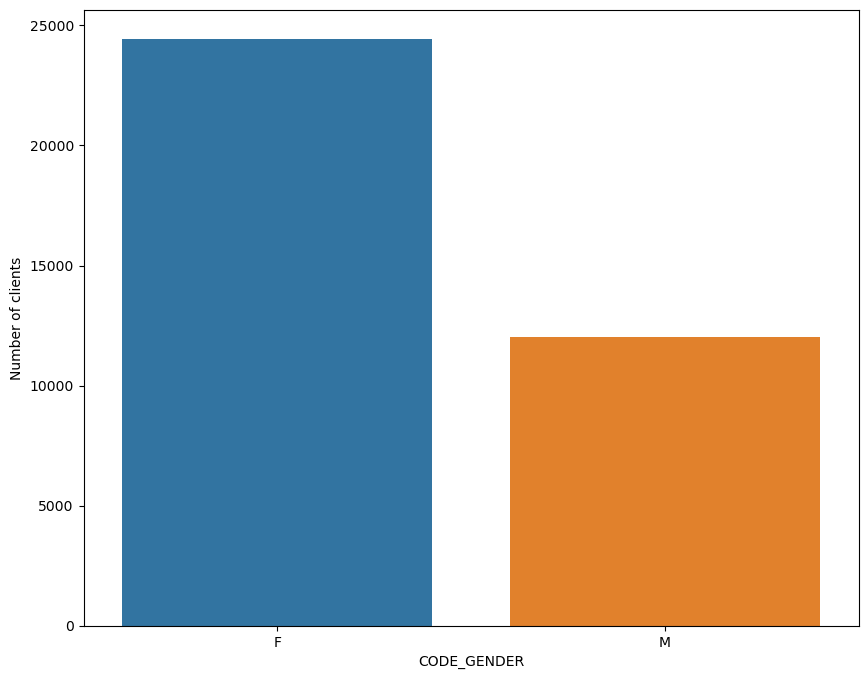

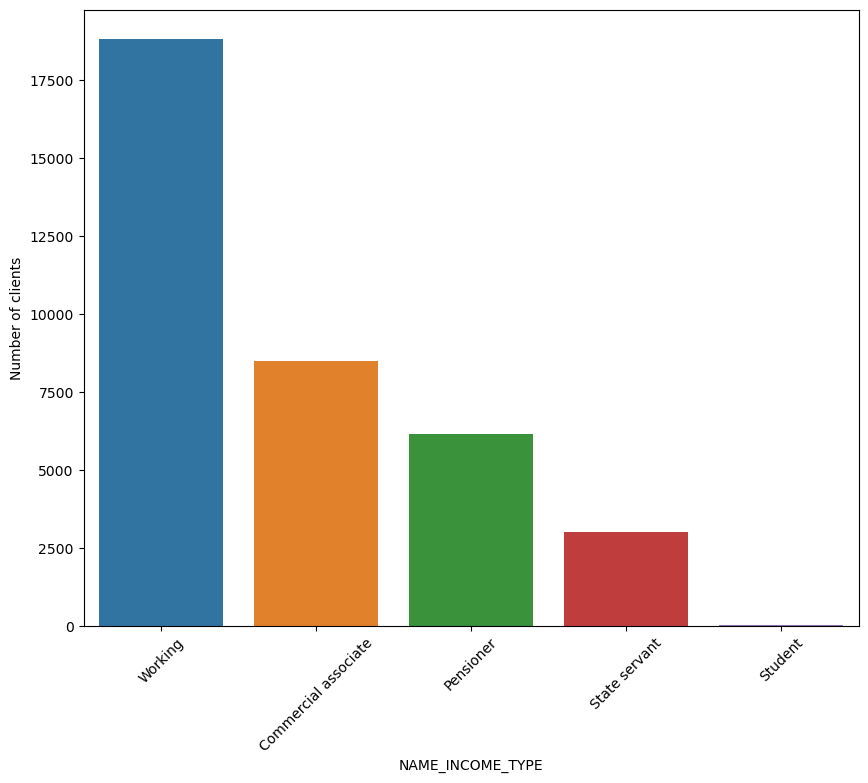

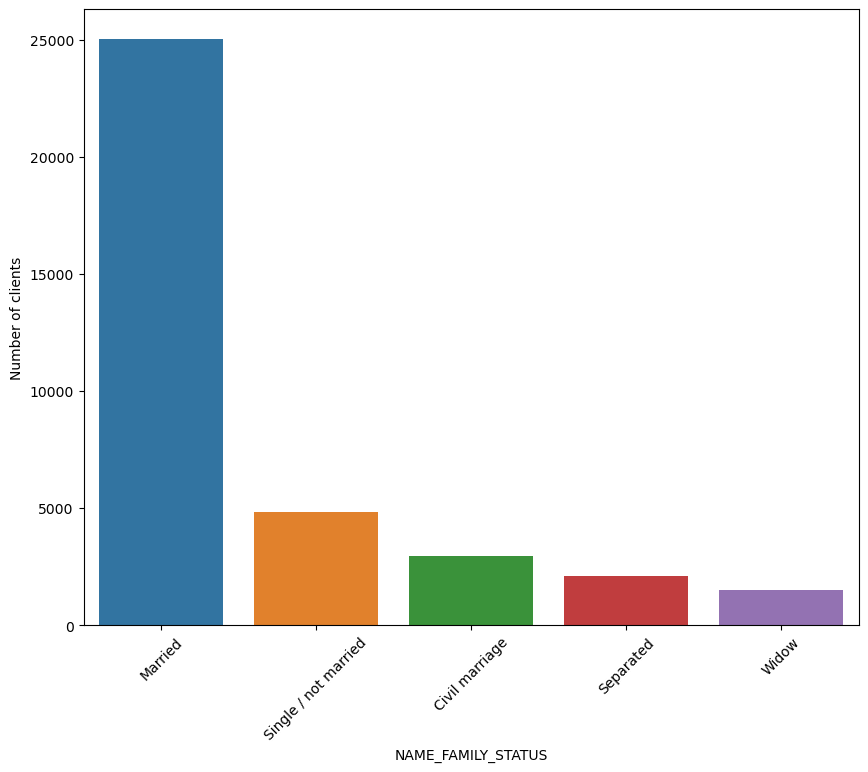

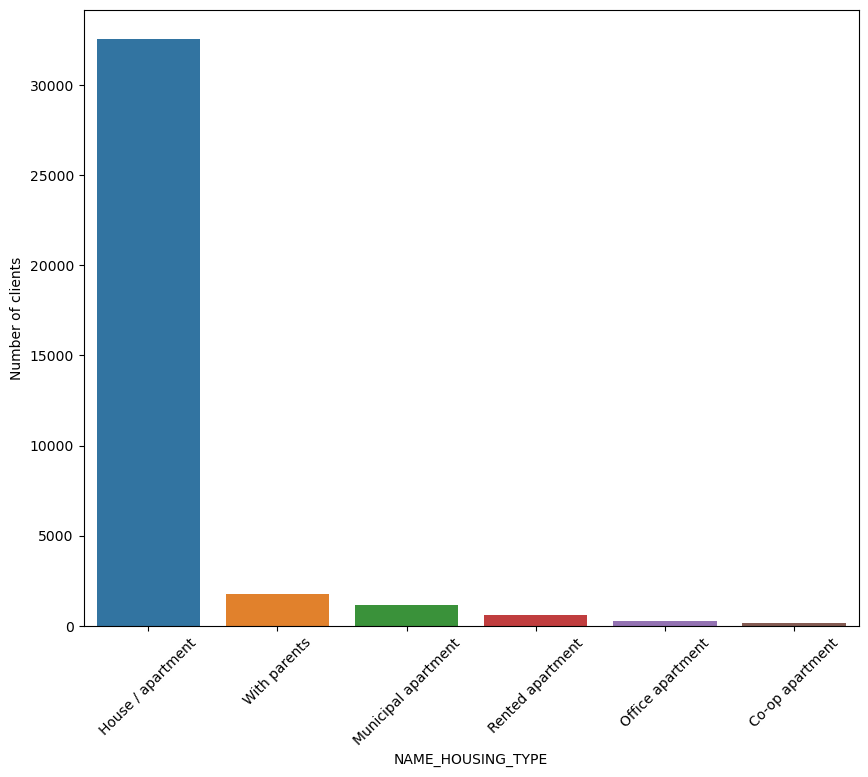

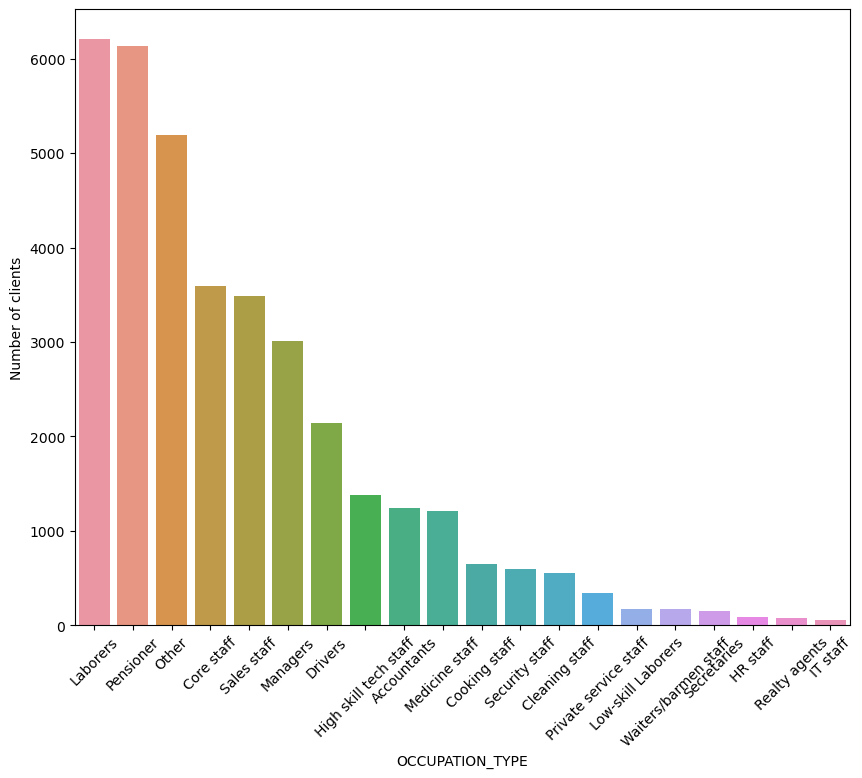

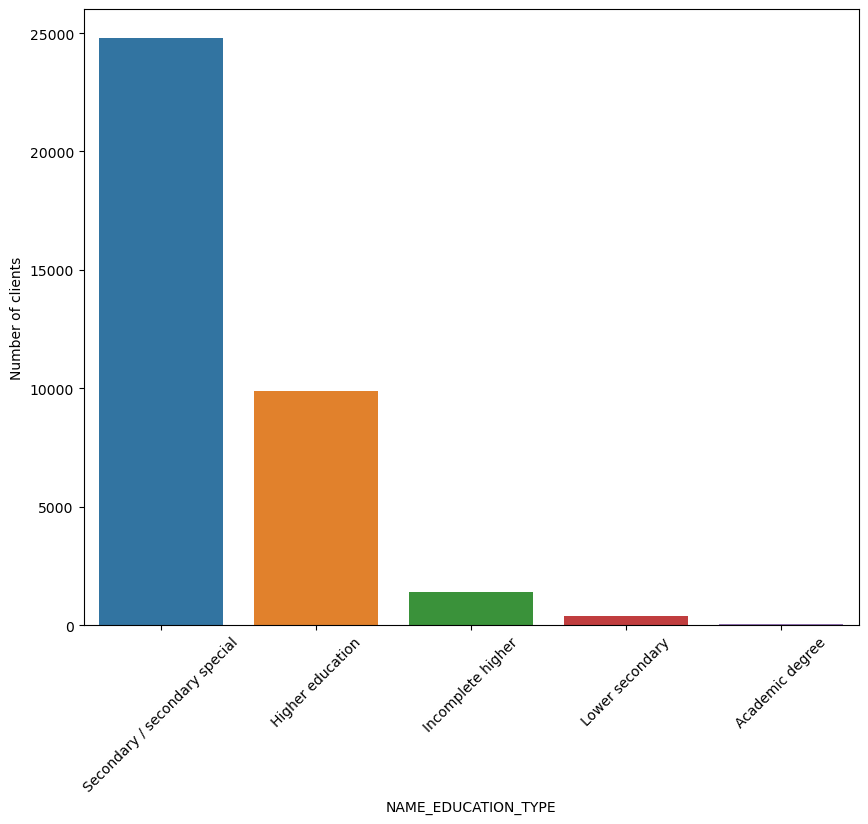

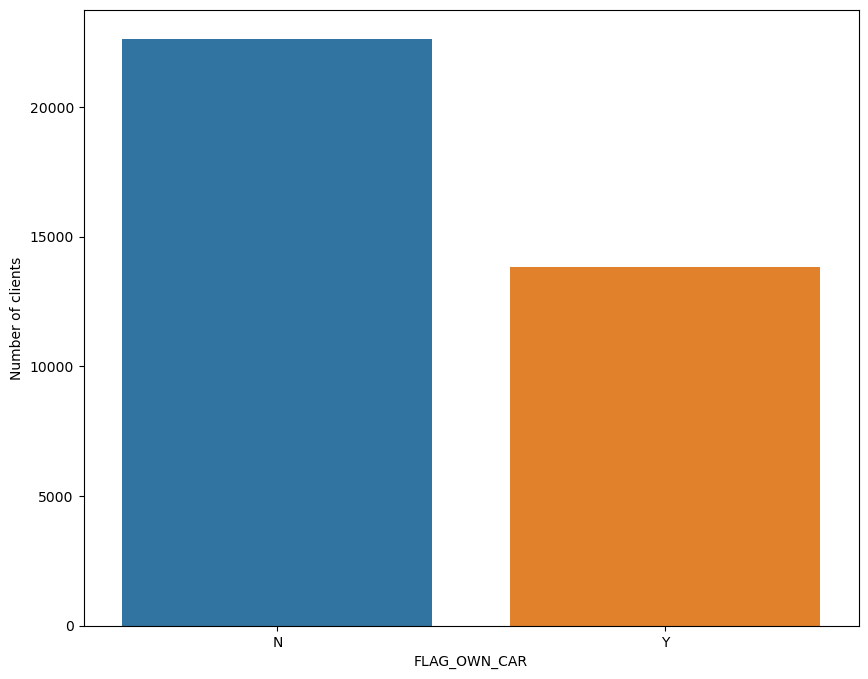

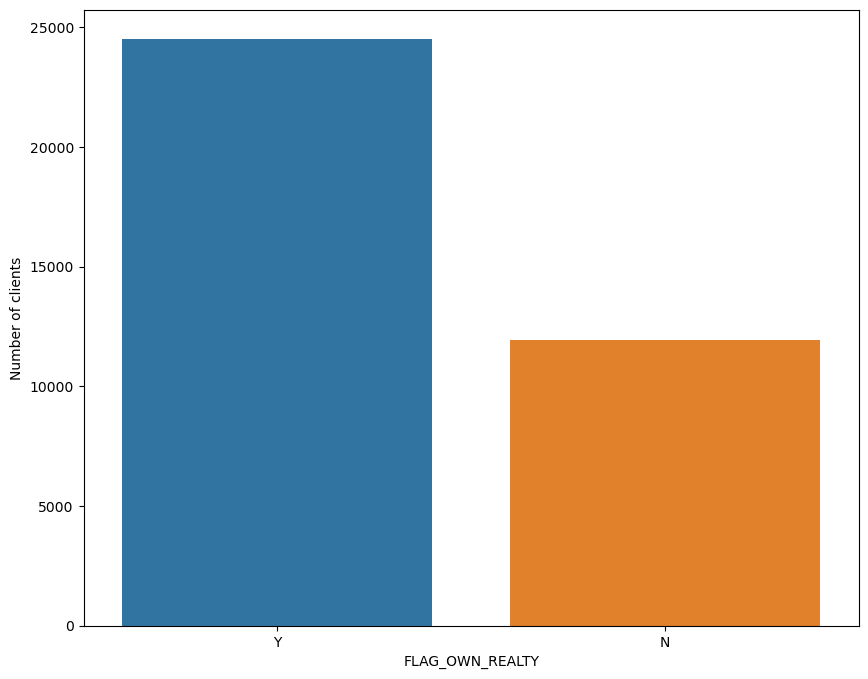

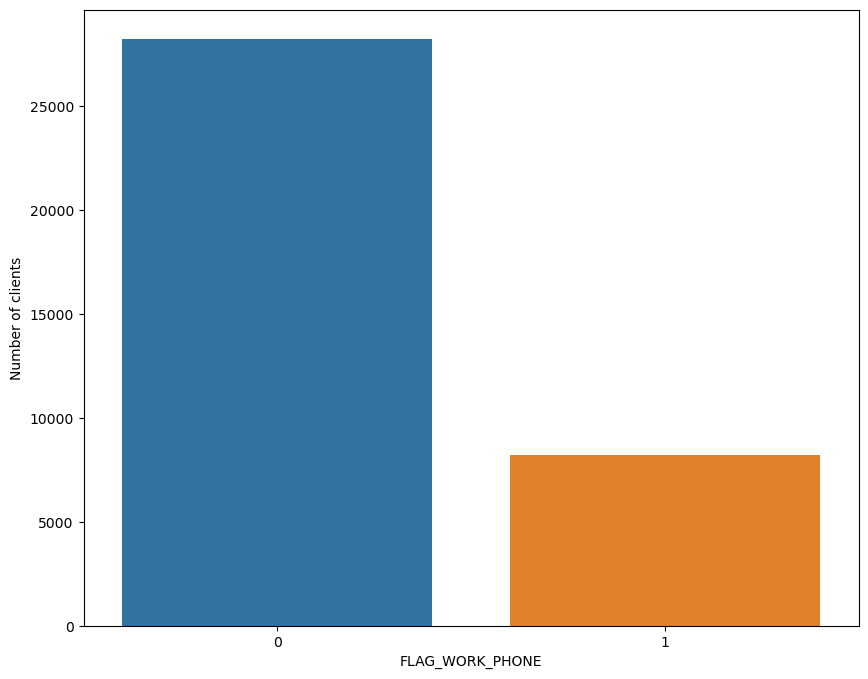

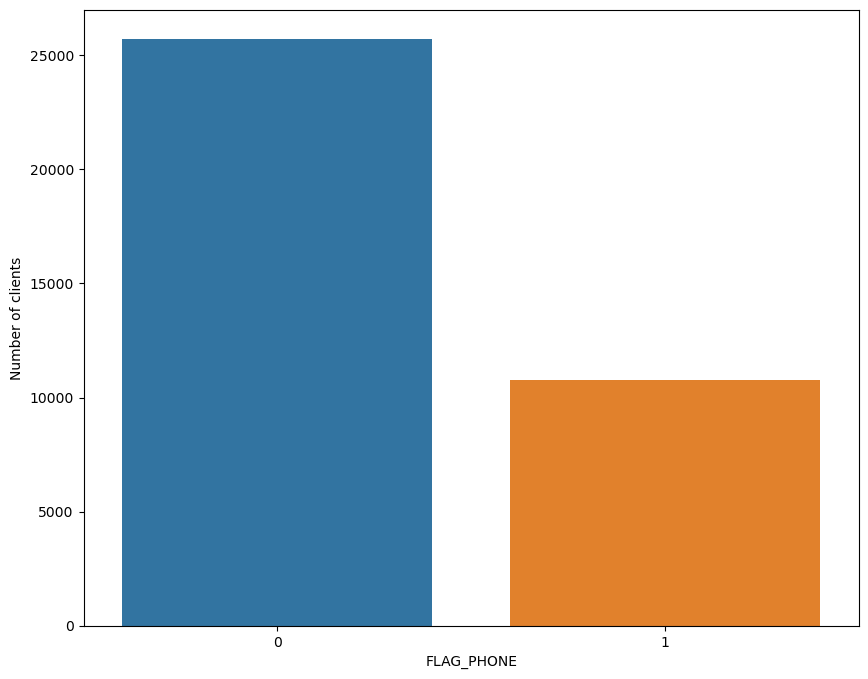

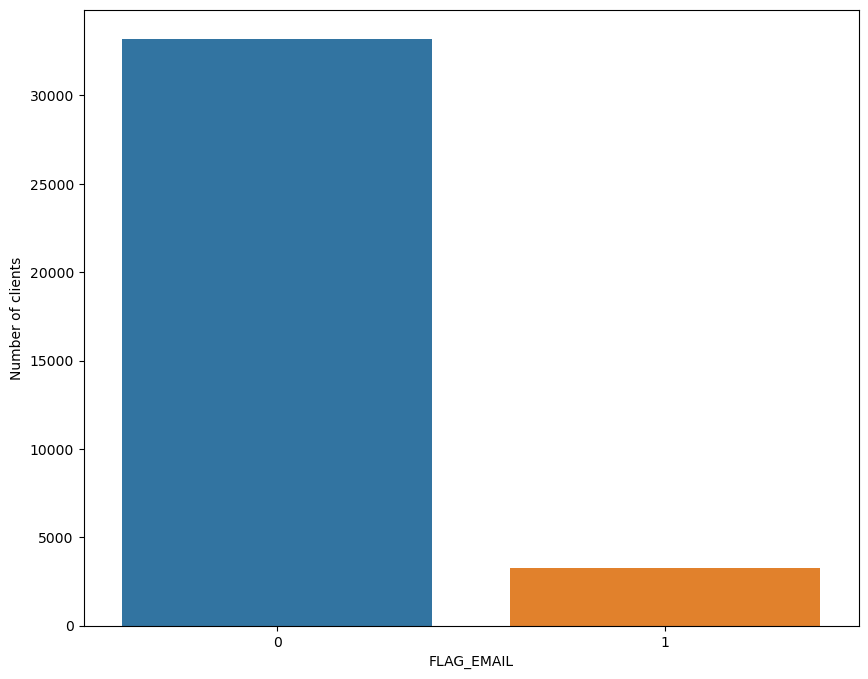

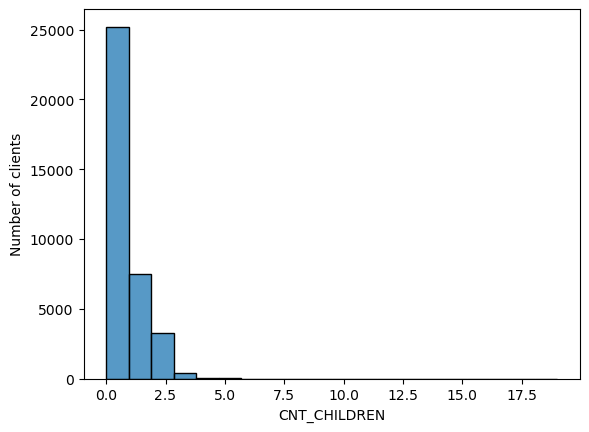

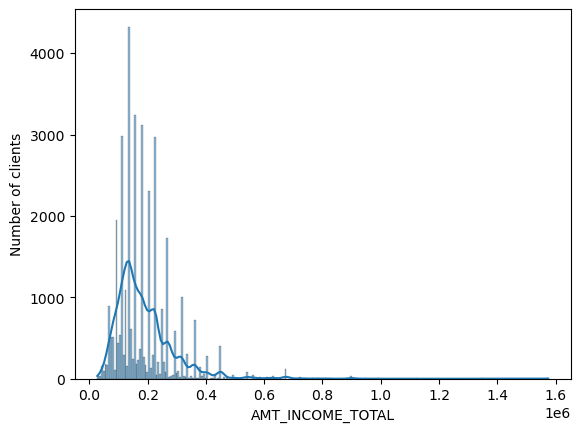

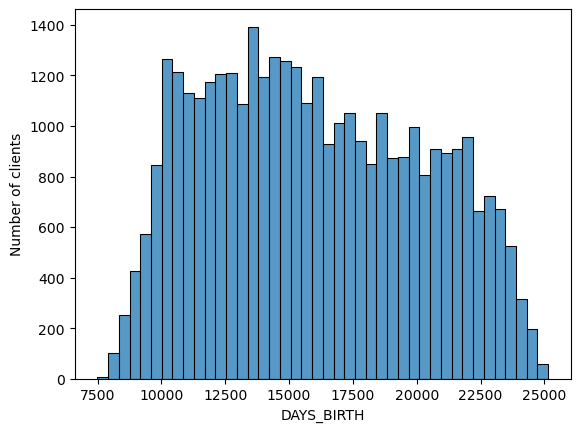

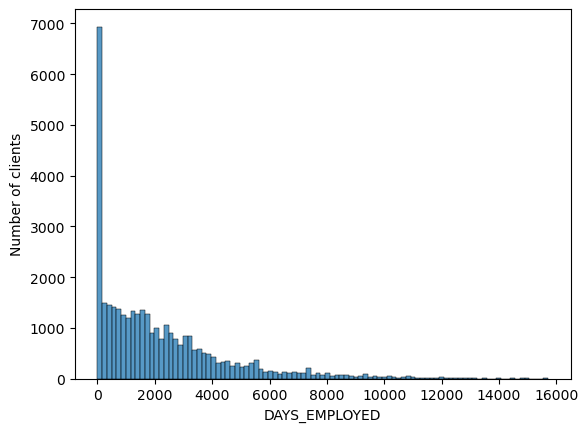

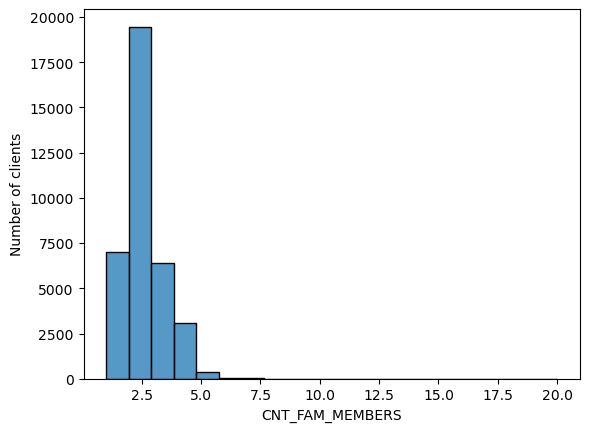

In [26]:
# Visualizziamo la distribuzione delle variabili

numeric_cols = ["CNT_CHILDREN",
                "AMT_INCOME_TOTAL",
                "DAYS_BIRTH",
                "DAYS_EMPLOYED",
                "CNT_FAM_MEMBERS"]

binary_cols = ["FLAG_OWN_CAR",
               "FLAG_OWN_REALTY",
               "FLAG_WORK_PHONE",
               "FLAG_PHONE",
               "FLAG_EMAIL"]

ordinal_cols = ["NAME_EDUCATION_TYPE"]

categoric_cols = ["CODE_GENDER",
                  "NAME_INCOME_TYPE",
                  "NAME_FAMILY_STATUS",
                  "NAME_HOUSING_TYPE",
                  "OCCUPATION_TYPE"]

for col in categoric_cols:
    create_barplot(col)
        
for col in ordinal_cols:
    create_barplot(col)
    
for col in binary_cols:
    create_barplot(col)
    
for col in numeric_cols:
    create_histogram(col)

# PREPROCESSING

In [27]:
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,RELIABLE_CLIENT
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2.0,1
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2.0,1
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,1
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,1
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,1


## Feature encoding

In [28]:
# Variabili binarie
car_mapping = {"Y": 1, "N": 0}
df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].map(lambda t:car_mapping[t])

realty_mapping = {"Y": 1, "N": 0}
df["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].map(lambda t:realty_mapping[t])

#######################################################################################

# Variabile ordinale

education_mapping = {
    "Lower secondary": 1,
    "Secondary / secondary special": 2,
    "Incomplete higher": 3,
    "Higher education": 4,
    "Academic degree": 5
}
df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].map(lambda t:education_mapping[t])

##########################################################################################

# Variabili categoriche
df = pd.get_dummies(df, columns=categoric_cols, drop_first=True)

## Feature selection

<Axes: >

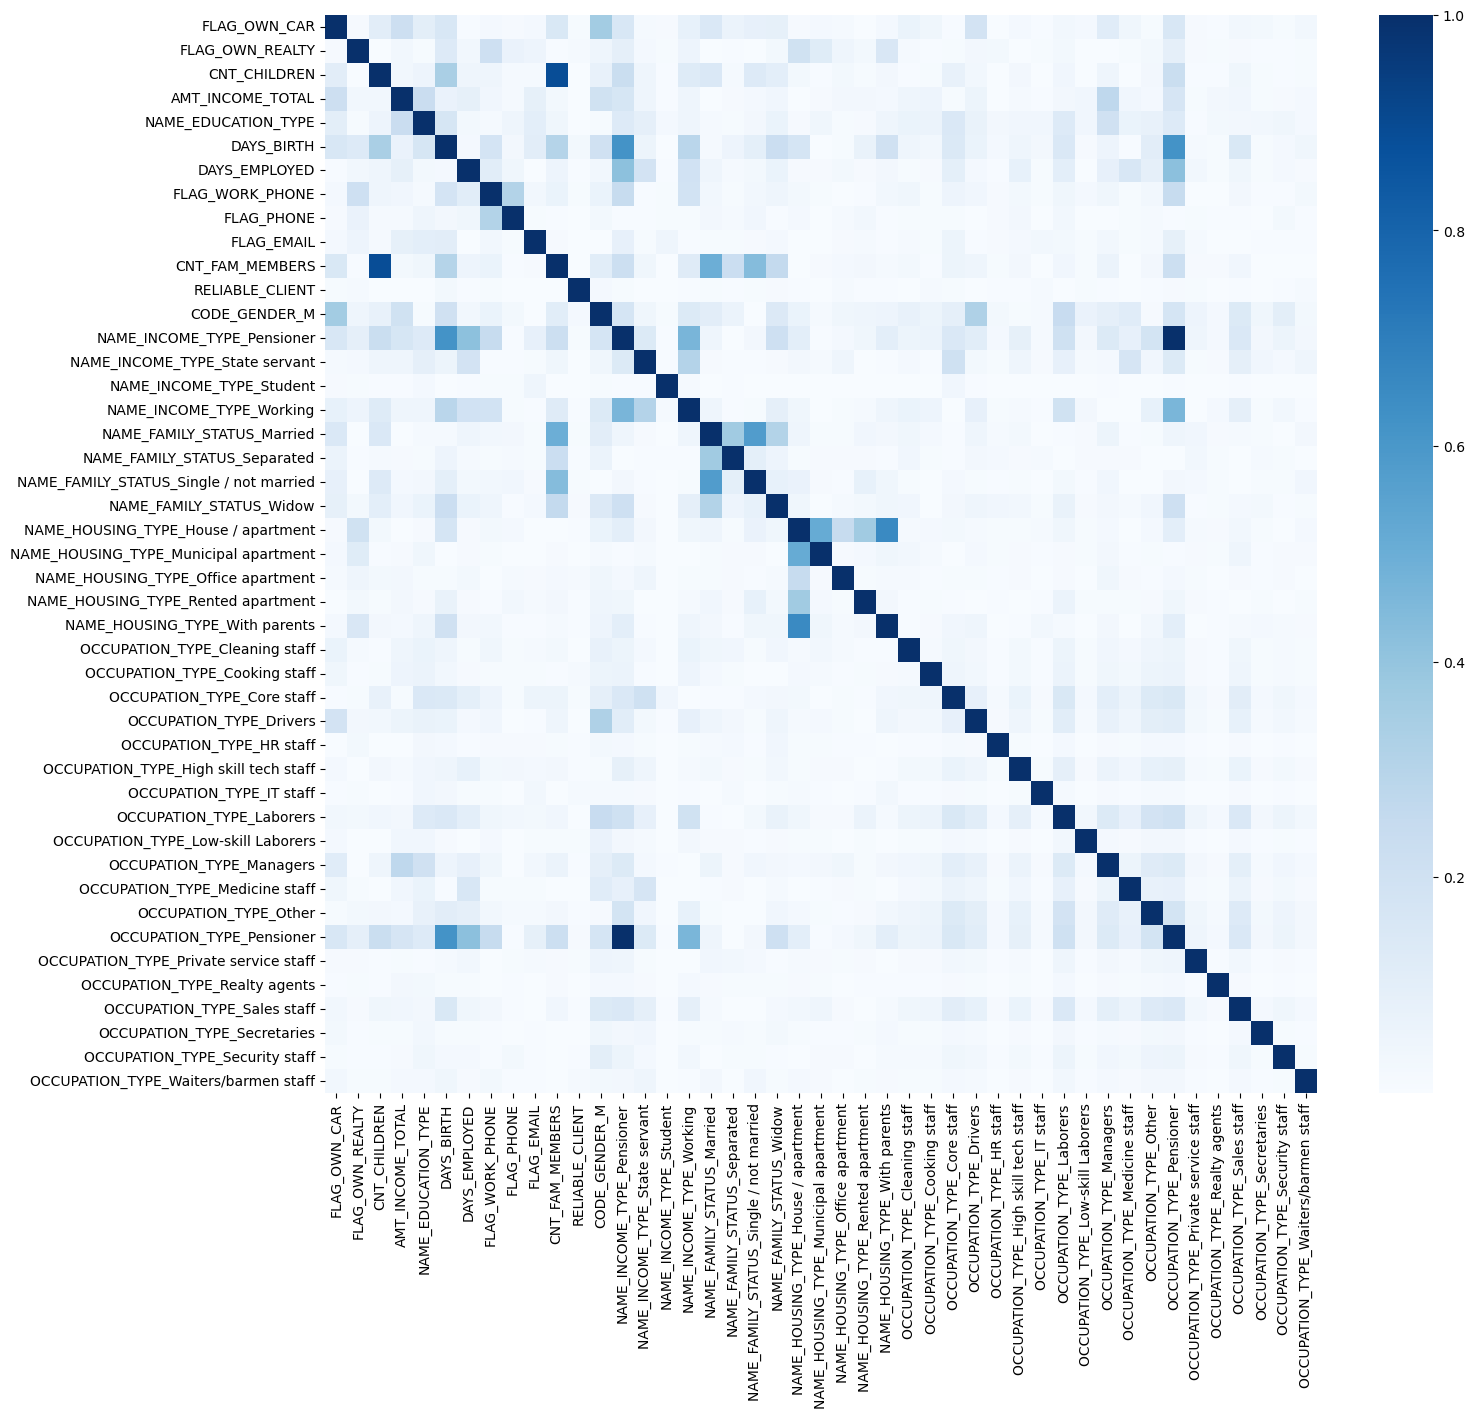

In [29]:
plt.figure(figsize=(16, 14))
sns.heatmap(np.abs(df.corr()), cmap="Blues")

In [30]:
# Elimino le feature con alta multicollinearità 
df = df.drop(["OCCUPATION_TYPE_Pensioner", "CNT_FAM_MEMBERS"],
             axis=1)    

<Axes: >

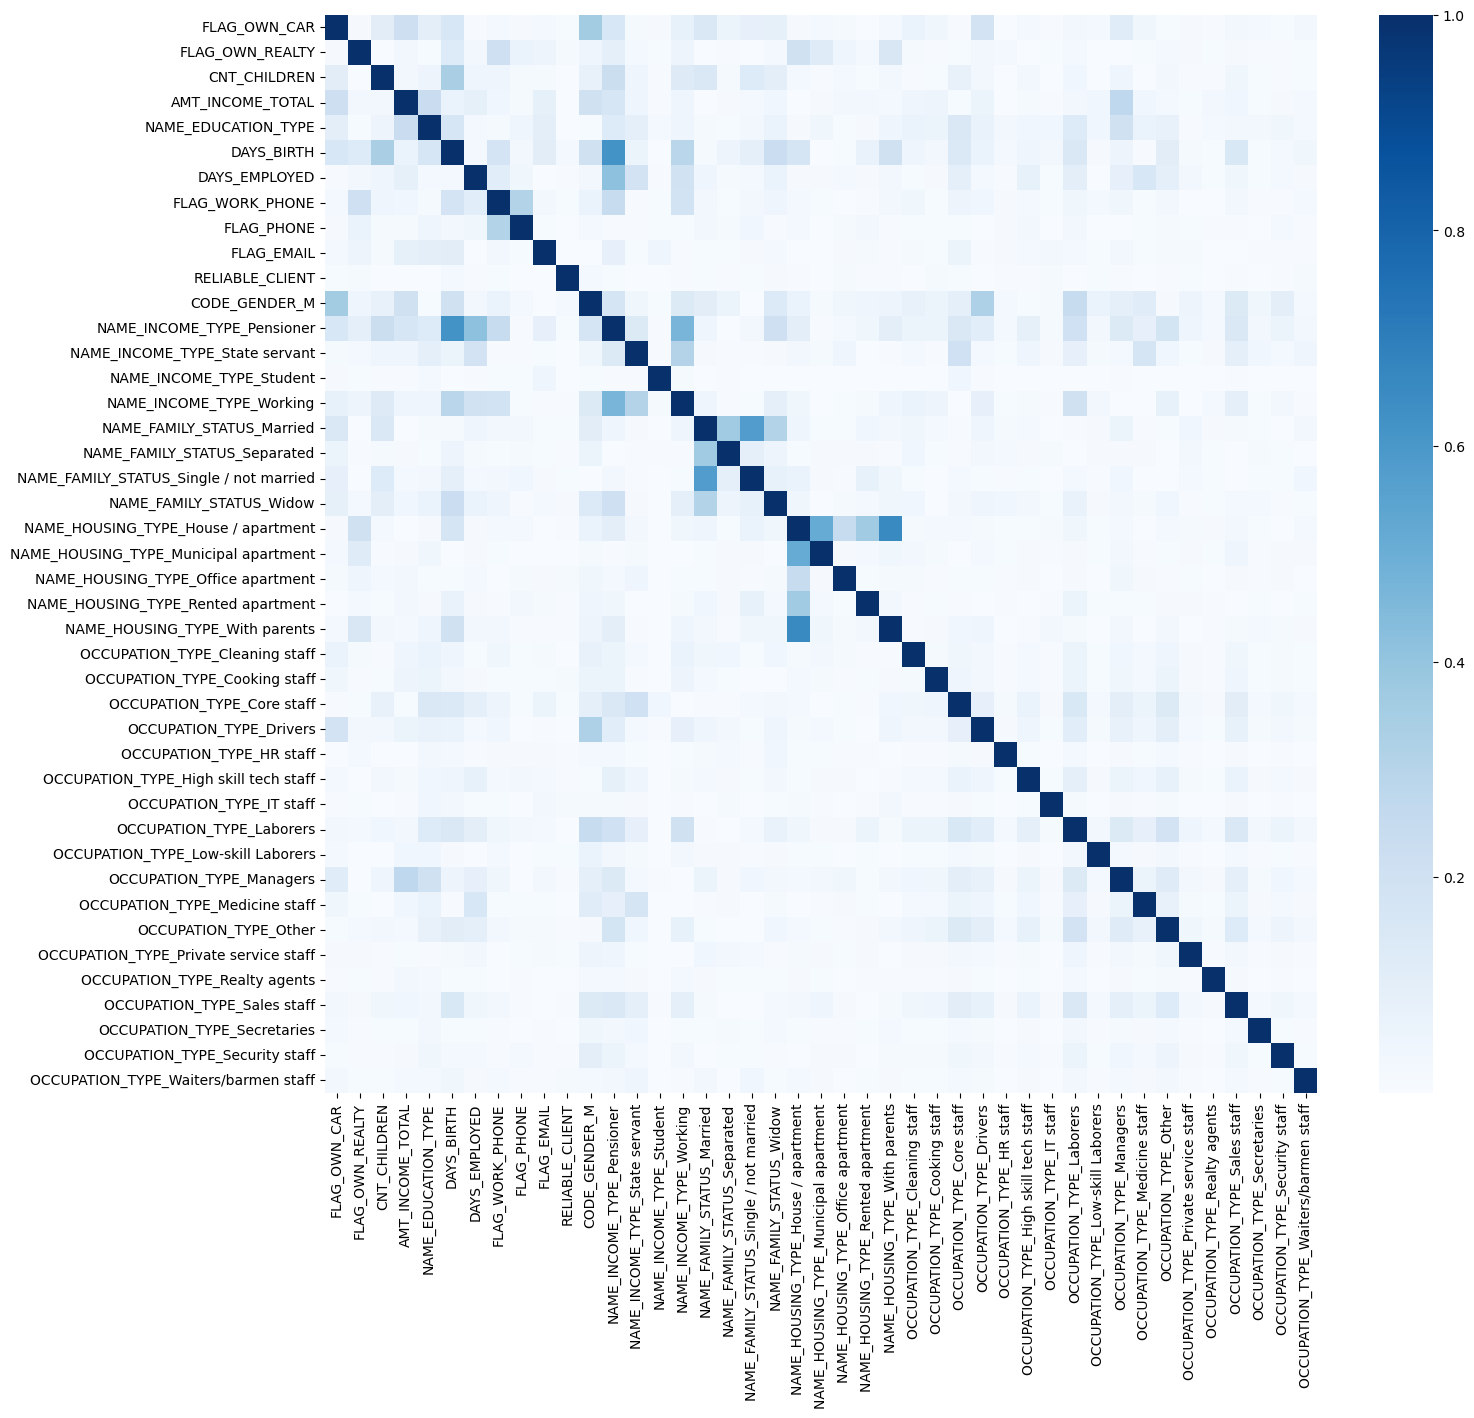

In [31]:
plt.figure(figsize=(16, 14))
sns.heatmap(np.abs(df.corr()), cmap="Blues")

## Train test split

In [32]:
X = df.drop("RELIABLE_CLIENT", axis=1).values
y = df["RELIABLE_CLIENT"].values
print(Counter(y))    # Variabile target MOLTO SBILANCIATA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

Counter({1: 35478, 0: 979})
(29165, 42) (7292, 42)


## Oversampling and feature scaling

In [33]:
oversample = SMOTE(sampling_strategy="auto", random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(Counter(y_train))    # Ora le classi della var target sono bilanciate

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Counter({1: 28389, 0: 28389})


In [34]:
_X_train, _X_test, _y_train, _y_test = X_train, X_test, y_train, y_test

# MODELING

In [35]:
def classification_reports(model_name, model, train_data, test_data):
    X_train, y_train = train_data
    X_test, y_test = test_data
    
    print(model_name)
    print("TRAIN SET -------------------------------------------")
    print(classification_report(y_train, model.predict(X_train)))
    print("TEST SET --------------------------------------------")
    print(classification_report(y_test, model.predict(X_test)))

In [36]:
# Non metto KNN perché i risultati devono essere interpretabili (con KNN non lo sono)
# Non metto SVM perché il dataset ha un numero medio-alto di esempi
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Neural Network": MLPClassifier(random_state=42)
}

In [ ]:
for model_name, model in models.items():
    
    X_train, X_test, y_train, y_test = _X_train, _X_test, _y_train, _y_test

    tick = time()
    model.fit(X_train, y_train)
    end_time = time() - tick
    print(f"\n\n\n --- {model_name} trained in {end_time:.2f} seconds ---")
    
    classification_reports(model_name, model, (X_train, y_train), (X_test, y_test))




 --- Logistic Regression trained in 0.34 seconds ---
Logistic Regression
TRAIN SET -------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.56      0.57     28389
           1       0.58      0.61      0.59     28389

    accuracy                           0.58     56778
   macro avg       0.58      0.58      0.58     56778
weighted avg       0.58      0.58      0.58     56778

TEST SET --------------------------------------------
              precision    recall  f1-score   support

           0       0.04      0.51      0.07       203
           1       0.98      0.61      0.75      7089

    accuracy                           0.61      7292
   macro avg       0.51      0.56      0.41      7292
weighted avg       0.95      0.61      0.73      7292




 --- Decision Tree trained in 0.30 seconds ---
Decision Tree
TRAIN SET -------------------------------------------
              precision    recall  f1-score 

# RESULTS

Siccome il dataset è estremamente sbilanciato (circa 40:1) in favore dei clienti affidabili, suppongo che la parte più importante del modello sia evitare i clienti non affidabili (minimizzare i falsi positivi), senza penalizzare troppo l'accettazione dei clienti affidabili.  <br><br>
Ciò significa massimizzare il recall per la classe 0, e come metrica per monitorare che le prestazioni non siano troppo sbilanciate in favore di ciò possiamo usare il F1 score (average="macro").

Il modello con recall più alto per la classe negativa nel set di test è una semplice regressione lineare (recall 0.51) ma con un F1 score scarso. Considerando tutto, il Decision Tree ha il punteggio migliore sia per recall della classe negativa (0.36) che per F1 score (0.67).

# INTERPRETABILITY

In [ ]:
# Mostro l'interpretabilità per il decision tree
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

feature_importances = dtc.feature_importances_
feature_names = df.drop("RELIABLE_CLIENT", axis=1).columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.show()

La feature che ha un impatto più significativo nel modello è di gran lunga essere proprietario di un immobile (`FLAG_OWN_REALTY`).